In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from scipy.stats import uniform
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
SCORING = 'balanced_accuracy'
cv=StratifiedKFold(n_splits=5)

In [4]:
X_train_versions = {
    'raw': pd.read_csv('pc_X_train.csv'),
    'pca60': pd.read_csv('pc_X_train_pca_60.csv'),
    'pca85': pd.read_csv('pc_X_train_pca_85.csv'),
    'vif': pd.read_csv('pc_X_train_vif.csv')
}

X_test_versions = {
    'raw': pd.read_csv('pc_X_test.csv'),
    'pca60': pd.read_csv('pc_X_test_pca_60.csv'),
    'pca85': pd.read_csv('pc_X_test_pca_85.csv'),
    'vif': pd.read_csv('pc_X_test_vif.csv')
}

y_train = pd.read_csv('pc_y_train.csv')["failure_prone"].values
y_test = pd.read_csv('y_baseline.csv')

In [5]:
results_file="model_results.csv"

In [24]:
def run_model(model, X_train_version, features= None, param_grid=None, n_iter=10):
    if features is None:
        X_train = X_train_versions[X_train_version]
        X_test = X_test_versions[X_train_version]
    else:
        X_train = X_train_versions[X_train_version][features]
        X_test = X_test_versions[X_train_version][features]
    
    # Split Data
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
    )

    start_time = time.time()
    if param_grid:
        grid_search = RandomizedSearchCV(
            model,
            param_grid,
            scoring=SCORING,
            cv=cv,
            n_jobs=-1,
            verbose=0,
            random_state = RANDOM_SEED
        )
        grid_search.fit(X_train_split, y_train_split)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best Parameters: {best_params}")
    else:
        best_model = model
        best_params=None
        best_model.fit(X_train_split, y_train_split)
    
    end_time = time.time()  # End timing
    training_time = end_time - start_time
    print(f"Time to train model: {training_time:.2f} seconds")
    
    y_pred_split = best_model.predict(X_train_split)
    y_pred_split = (y_pred_split >= 0.5).astype(int)
    train_bal_acc = balanced_accuracy_score(y_train_split, y_pred_split)
    print(f"Balanced Accuracy (Train): {train_bal_acc:.4f}")
    
    # Evaluate on Test Set
    y_pred_split = best_model.predict(X_test_split)
    y_pred_split = (y_pred_split >= 0.5).astype(int)
    test_bal_acc = balanced_accuracy_score(y_test_split, y_pred_split)
    print(f"Balanced Accuracy (Test): {test_bal_acc:.4f}")
    print("Classification Report:\n", classification_report(y_test_split, y_pred_split))

    cm = confusion_matrix(y_test_split, y_pred_split)

    plt.figure(figsize=(6, 4))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
    cm_display.plot()
    plt.show()

    if not os.path.exists(results_file):
        id_count = 0
    else:
        id_count = len(pd.read_csv(results_file))
    
    identifier = f"{id_count}-{type(best_model).__name__}"
    filename = f"submit/{test_bal_acc:.4f}-{identifier}.csv"
    
    results_df = pd.DataFrame({
        "id": [id_count],
        "training_time": [training_time],
        "train_bal_acc": [train_bal_acc],
        "test_bal_acc": [test_bal_acc],
        "model": [type(best_model).__name__],
        "dataset_version": [X_train_version],
        "features": [str(features)],
        "best_params": [str(best_params)]
    })
    
    if not os.path.exists(results_file):
        results_df.to_csv(results_file, index=False)
    else:
        results_df.to_csv(results_file, mode='a', header=False, index=False)

    best_model.fit(X_train, y_train)
    y_test["failure_prone"] = best_model.predict(X_test)
    y_test.to_csv(filename, index=False)

In [10]:
def feature_RFECV(model):
    rfecv = RFECV(
    estimator=model,
    step=1,  # Remove one feature at a time
    cv=cv,  # Cross-validation strategy
    scoring=SCORING,  # Metric to optimize
    min_features_to_select=1,  # Ensure at least one feature is selected
    n_jobs=-1
    )
    
    # Fit RFECV on the dataset
    rfecv.fit(X_train_versions['raw'], y_train)

    selected_features = X_train_versions['raw'].columns[rfecv.support_]
    
    # Optimal number of features
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {selected_features}")
    
    plt.figure(figsize=(6, 4))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation balanced accuracy")
    plt.title(f"RFECV - Feature Selection - Max:{round(max(rfecv.cv_results_["mean_test_score"]), 4)}")
    plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
    plt.show()
    return selected_features

## Naive Bayes

Time to train model: 0.20 seconds
Balanced Accuracy (Train): 0.5855
Balanced Accuracy (Test): 0.5854
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     29890
           1       0.18      0.24      0.21      1928

    accuracy                           0.89     31818
   macro avg       0.56      0.59      0.57     31818
weighted avg       0.90      0.89      0.89     31818



<Figure size 600x400 with 0 Axes>

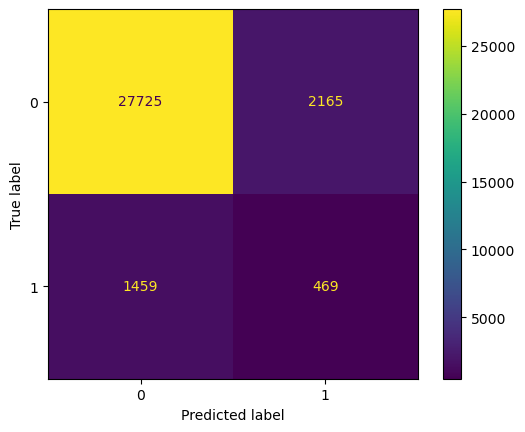

In [37]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
run_model(model, "raw")

Time to train model: 0.15 seconds
Balanced Accuracy (Train): 0.5877
Balanced Accuracy (Test): 0.5865
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93     29890
           1       0.17      0.26      0.20      1928

    accuracy                           0.88     31818
   macro avg       0.56      0.59      0.57     31818
weighted avg       0.90      0.88      0.89     31818



<Figure size 600x400 with 0 Axes>

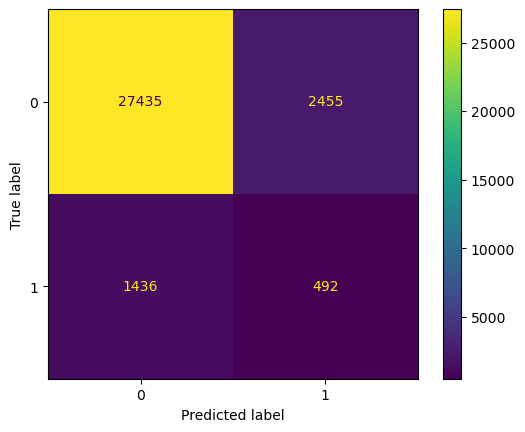

In [39]:
run_model(model, "vif")

Time to train model: 0.16 seconds
Balanced Accuracy (Train): 0.5707
Balanced Accuracy (Test): 0.5732
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     29890
           1       0.17      0.21      0.19      1928

    accuracy                           0.89     31818
   macro avg       0.56      0.57      0.57     31818
weighted avg       0.90      0.89      0.90     31818



<Figure size 600x400 with 0 Axes>

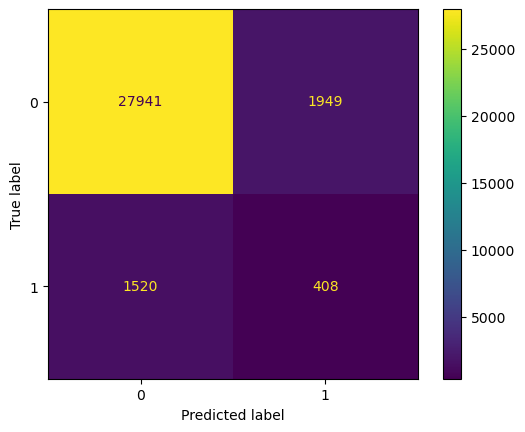

In [41]:
run_model(model, "pca85")

Time to train model: 0.11 seconds
Balanced Accuracy (Train): 0.5568
Balanced Accuracy (Test): 0.5619
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     29890
           1       0.16      0.18      0.17      1928

    accuracy                           0.89     31818
   macro avg       0.56      0.56      0.56     31818
weighted avg       0.90      0.89      0.90     31818



<Figure size 600x400 with 0 Axes>

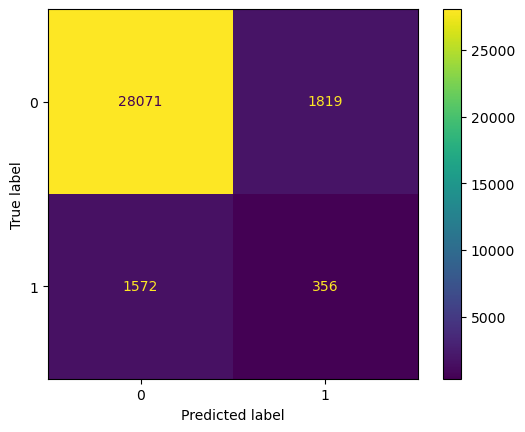

In [43]:
run_model(model, "pca60")

## Logistic Regression

Time to train model: 1.63 seconds
Balanced Accuracy (Train): 0.7084
Balanced Accuracy (Test): 0.7012
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.76      0.85     29890
           1       0.15      0.65      0.24      1928

    accuracy                           0.75     31818
   macro avg       0.56      0.70      0.54     31818
weighted avg       0.92      0.75      0.81     31818



<Figure size 600x400 with 0 Axes>

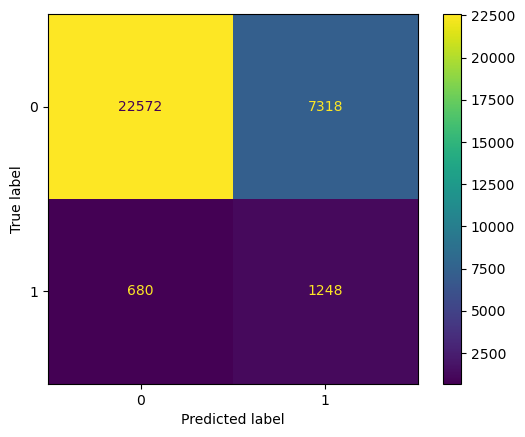

In [45]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', random_state=RANDOM_SEED)
run_model(model, "raw")

Time to train model: 1.64 seconds
Balanced Accuracy (Train): 0.6996
Balanced Accuracy (Test): 0.6938
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.75      0.84     29890
           1       0.14      0.64      0.23      1928

    accuracy                           0.74     31818
   macro avg       0.56      0.69      0.54     31818
weighted avg       0.92      0.74      0.81     31818



<Figure size 600x400 with 0 Axes>

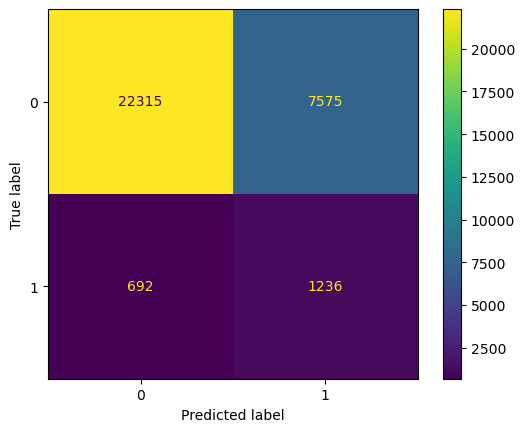

In [46]:
run_model(model, "vif")

Time to train model: 1.05 seconds
Balanced Accuracy (Train): 0.7033
Balanced Accuracy (Test): 0.6989
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.76      0.85     29890
           1       0.15      0.64      0.24      1928

    accuracy                           0.75     31818
   macro avg       0.56      0.70      0.54     31818
weighted avg       0.92      0.75      0.81     31818



<Figure size 600x400 with 0 Axes>

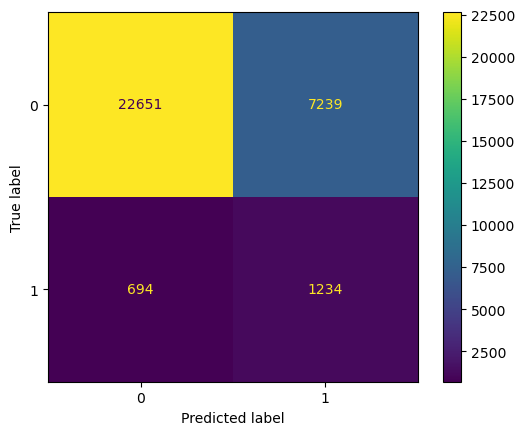

In [48]:
run_model(model, "pca85")

Time to train model: 0.89 seconds
Balanced Accuracy (Train): 0.6887
Balanced Accuracy (Test): 0.6837
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.78      0.86     29890
           1       0.15      0.59      0.23      1928

    accuracy                           0.77     31818
   macro avg       0.56      0.68      0.55     31818
weighted avg       0.92      0.77      0.82     31818



<Figure size 600x400 with 0 Axes>

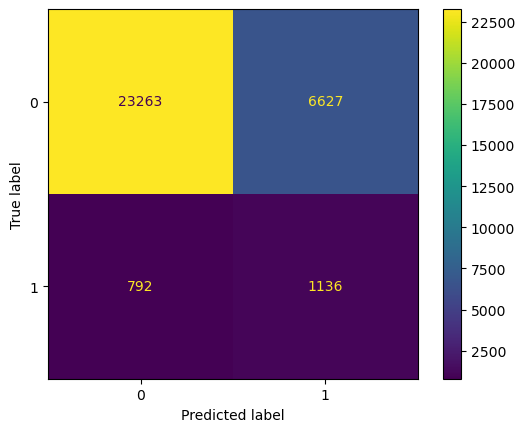

In [50]:
run_model(model, "pca60")

In [52]:
param_grid = {'penalty': ['l2', 'none'],
              'tol': np.logspace(start=-5, stop=-3, num=10),
              'C': np.linspace(start=0, stop=2, num=10),
              'class_weight': ['balanced', None],
              'solver': ['lbfgs', 'sag', 'saga'],
              'fit_intercept': [False, True]}

Best Parameters: {'tol': 0.001, 'solver': 'lbfgs', 'penalty': 'l2', 'fit_intercept': False, 'class_weight': 'balanced', 'C': 2.0}
Time to train model: 38.19 seconds
Balanced Accuracy (Train): 0.7080
Balanced Accuracy (Test): 0.7008
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.59      0.73     29890
           1       0.11      0.81      0.20      1928

    accuracy                           0.60     31818
   macro avg       0.55      0.70      0.47     31818
weighted avg       0.93      0.60      0.70     31818



<Figure size 600x400 with 0 Axes>

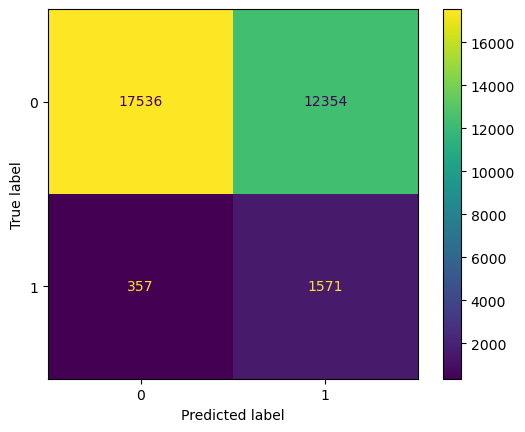

In [55]:
run_model(model, "raw", param_grid=param_grid, n_iter=30)

Best Parameters: {'tol': 0.001, 'solver': 'lbfgs', 'penalty': 'l2', 'fit_intercept': False, 'class_weight': 'balanced', 'C': 2.0}
Time to train model: 27.91 seconds
Balanced Accuracy (Train): 0.7000
Balanced Accuracy (Test): 0.6896
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.58      0.73     29890
           1       0.11      0.79      0.19      1928

    accuracy                           0.60     31818
   macro avg       0.54      0.69      0.46     31818
weighted avg       0.93      0.60      0.70     31818



<Figure size 600x400 with 0 Axes>

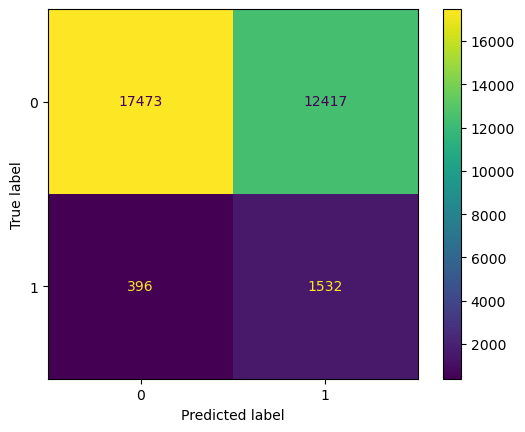

In [56]:
run_model(model, "vif", param_grid=param_grid, n_iter=30)

Best Parameters: {'tol': 0.001, 'solver': 'lbfgs', 'penalty': 'l2', 'fit_intercept': False, 'class_weight': 'balanced', 'C': 2.0}
Time to train model: 29.04 seconds
Balanced Accuracy (Train): 0.7055
Balanced Accuracy (Test): 0.7017
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.60      0.74     29890
           1       0.11      0.81      0.20      1928

    accuracy                           0.61     31818
   macro avg       0.55      0.70      0.47     31818
weighted avg       0.93      0.61      0.71     31818



<Figure size 600x400 with 0 Axes>

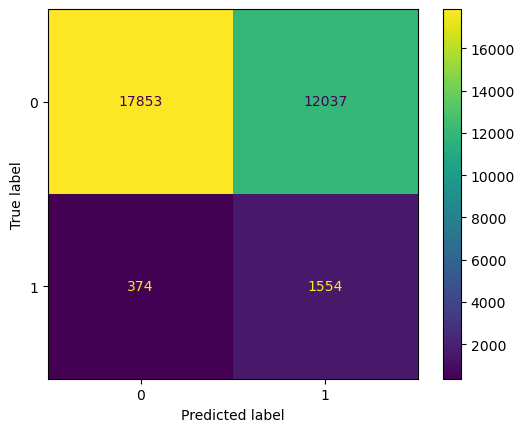

In [57]:
run_model(model, "pca85", param_grid=param_grid, n_iter=30)

Best Parameters: {'tol': 1e-05, 'solver': 'saga', 'penalty': 'l2', 'fit_intercept': False, 'class_weight': None, 'C': 0.6666666666666666}
Time to train model: 32.96 seconds
Balanced Accuracy (Train): 0.6840
Balanced Accuracy (Test): 0.6807
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.71      0.82     29890
           1       0.13      0.65      0.21      1928

    accuracy                           0.71     31818
   macro avg       0.55      0.68      0.52     31818
weighted avg       0.92      0.71      0.79     31818



<Figure size 600x400 with 0 Axes>

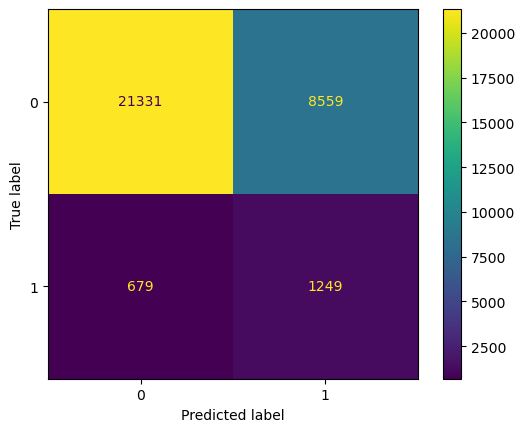

In [58]:
run_model(model, "pca60", param_grid=param_grid, n_iter=30)

Optimal number of features: 69
Selected features: Index(['additions', 'additions_max', 'avg_play_size', 'avg_task_size',
       'change_set_avg', 'change_set_max', 'code_churn_avg',
       'code_churn_count', 'code_churn_max', 'commits_count',
       'contributors_count', 'deletions', 'deletions_avg',
       'highest_contributor_experience', 'lines_blank', 'lines_code',
       'lines_comment', 'num_blocks', 'num_commands', 'num_conditions',
       'num_decisions', 'num_deprecated_keywords', 'num_deprecated_modules',
       'num_distinct_modules', 'num_external_modules', 'num_fact_modules',
       'num_file_exists', 'num_file_mode', 'num_file_modules', 'num_filters',
       'num_import_playbook', 'num_import_role', 'num_import_tasks',
       'num_include', 'num_include_role', 'num_include_tasks',
       'num_include_vars', 'num_keys', 'num_lookups', 'num_loops',
       'num_names_with_vars', 'num_parameters', 'num_paths', 'num_plays',
       'num_prompts', 'num_regex', 'num_suspicious_c

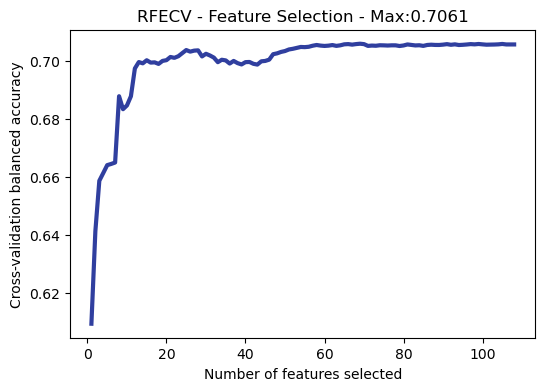

In [33]:
selected_features = feature_RFECV(model)

Best Parameters: {'tol': 0.001, 'solver': 'lbfgs', 'penalty': 'l2', 'fit_intercept': False, 'class_weight': 'balanced', 'C': 2.0}
Time to train model: 24.55 seconds
Balanced Accuracy (Train): 0.7082
Balanced Accuracy (Test): 0.7023
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.59      0.74     29890
           1       0.11      0.82      0.20      1928

    accuracy                           0.60     31818
   macro avg       0.55      0.70      0.47     31818
weighted avg       0.93      0.60      0.70     31818



<Figure size 600x400 with 0 Axes>

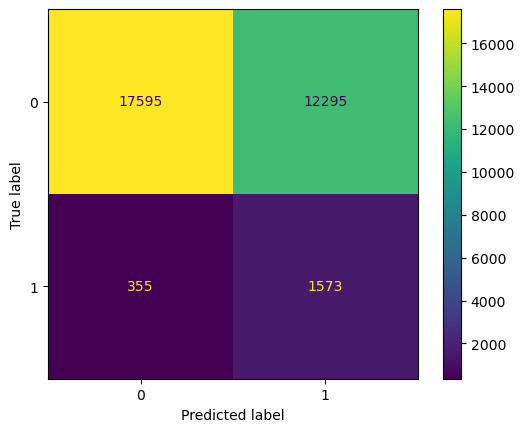

In [59]:
selected_features = ['additions', 'additions_max', 'avg_play_size', 'avg_task_size',
                     'change_set_avg', 'change_set_max', 'code_churn_avg',
                     'code_churn_count', 'code_churn_max', 'commits_count',
                     'contributors_count', 'deletions', 'deletions_avg',
                     'highest_contributor_experience', 'lines_blank', 'lines_code',
                     'lines_comment', 'num_blocks', 'num_commands', 'num_conditions',
                     'num_decisions', 'num_deprecated_keywords', 'num_deprecated_modules',
                     'num_distinct_modules', 'num_external_modules', 'num_fact_modules',
                     'num_file_exists', 'num_file_mode', 'num_file_modules', 'num_filters',
                     'num_import_playbook', 'num_import_role', 'num_import_tasks',
                     'num_include', 'num_include_role', 'num_include_tasks',
                     'num_include_vars', 'num_keys', 'num_lookups', 'num_loops',
                     'num_names_with_vars', 'num_parameters', 'num_paths', 'num_plays',
                     'num_prompts', 'num_regex', 'num_suspicious_comments', 'num_tasks',
                     'num_tokens', 'num_unique_names', 'num_uri', 'num_vars', 'text_entropy',
                     'delta_lines_code', 'delta_num_blocks', 'delta_num_commands',
                     'delta_num_conditions', 'delta_num_decisions', 'delta_num_fact_modules',
                     'delta_num_filters', 'delta_num_import_role', 'delta_num_keys',
                     'delta_num_names_with_vars', 'delta_num_prompts', 'delta_num_tasks',
                     'delta_num_tokens', 'delta_num_unique_names', 'delta_num_vars',
                     'delta_text_entropy']
run_model(model, "raw", selected_features, param_grid, n_iter=30)

## K-Neigbours

Time to train model: 0.05 seconds
Balanced Accuracy (Train): 0.8530
Balanced Accuracy (Test): 0.8051
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     29890
           1       0.79      0.62      0.69      1928

    accuracy                           0.97     31818
   macro avg       0.88      0.81      0.84     31818
weighted avg       0.96      0.97      0.97     31818



<Figure size 600x400 with 0 Axes>

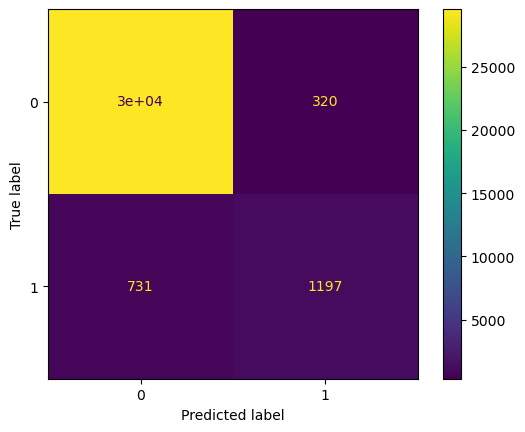

In [60]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
run_model(model, "raw")

Time to train model: 0.05 seconds
Balanced Accuracy (Train): 0.8380
Balanced Accuracy (Test): 0.7831
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     29890
           1       0.79      0.58      0.66      1928

    accuracy                           0.96     31818
   macro avg       0.88      0.78      0.82     31818
weighted avg       0.96      0.96      0.96     31818



<Figure size 600x400 with 0 Axes>

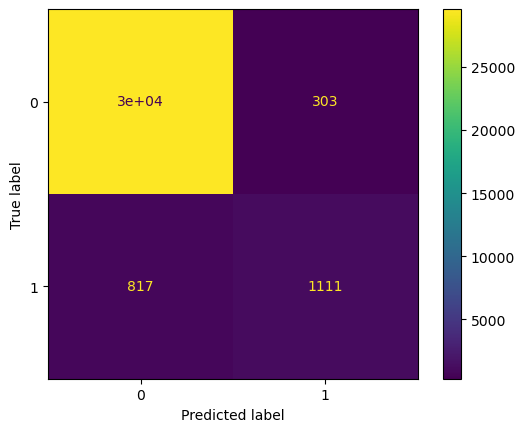

In [61]:
run_model(model, "vif")

Time to train model: 0.05 seconds
Balanced Accuracy (Train): 0.8500
Balanced Accuracy (Test): 0.8005
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     29890
           1       0.79      0.61      0.69      1928

    accuracy                           0.97     31818
   macro avg       0.88      0.80      0.84     31818
weighted avg       0.96      0.97      0.96     31818



<Figure size 600x400 with 0 Axes>

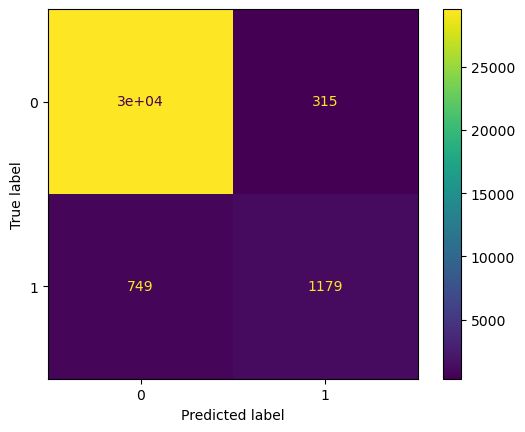

In [62]:
run_model(model, "pca85")

Time to train model: 0.04 seconds
Balanced Accuracy (Train): 0.8425
Balanced Accuracy (Test): 0.7885
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     29890
           1       0.77      0.59      0.67      1928

    accuracy                           0.96     31818
   macro avg       0.87      0.79      0.82     31818
weighted avg       0.96      0.96      0.96     31818



<Figure size 600x400 with 0 Axes>

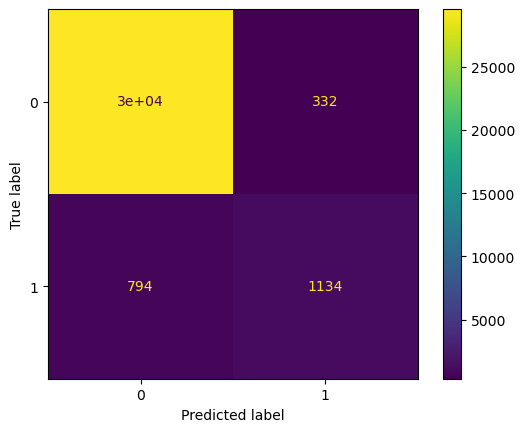

In [63]:
run_model(model, "pca60")

In [64]:
param_grid = {'n_neighbors' : [2, 3, 4],
              'weights' : ['uniform','distance'],
              'metric' : ['minkowski','euclidean','manhattan'],
              'p': [1, 2],
              'algorithm': ["ball_tree","kd_tree","brute"],
              }

Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
Time to train model: 2149.73 seconds
Balanced Accuracy (Train): 0.9861
Balanced Accuracy (Test): 0.8609
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     29890
           1       0.82      0.73      0.77      1928

    accuracy                           0.97     31818
   macro avg       0.90      0.86      0.88     31818
weighted avg       0.97      0.97      0.97     31818



<Figure size 600x400 with 0 Axes>

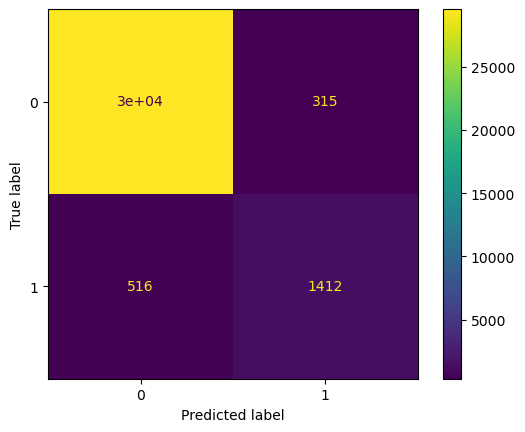

In [65]:
run_model(model, "raw", param_grid=param_grid, n_iter=10)

Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'metric': 'minkowski', 'algorithm': 'brute'}
Time to train model: 1583.28 seconds
Balanced Accuracy (Train): 0.9838
Balanced Accuracy (Test): 0.8469
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     29890
           1       0.80      0.70      0.75      1928

    accuracy                           0.97     31818
   macro avg       0.89      0.85      0.87     31818
weighted avg       0.97      0.97      0.97     31818



<Figure size 600x400 with 0 Axes>

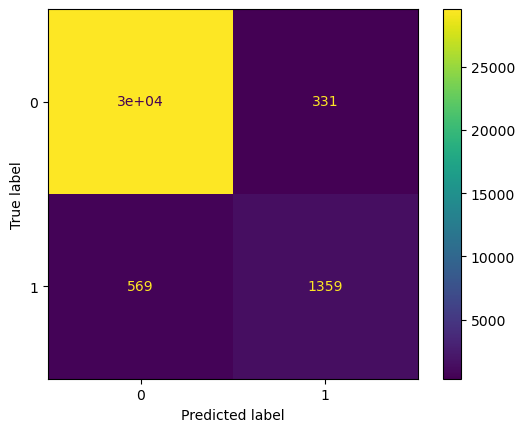

In [66]:
run_model(model, "vif", param_grid=param_grid, n_iter=10)

Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
Time to train model: 1432.77 seconds
Balanced Accuracy (Train): 0.9876
Balanced Accuracy (Test): 0.8386
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     29890
           1       0.80      0.69      0.74      1928

    accuracy                           0.97     31818
   macro avg       0.89      0.84      0.86     31818
weighted avg       0.97      0.97      0.97     31818



<Figure size 600x400 with 0 Axes>

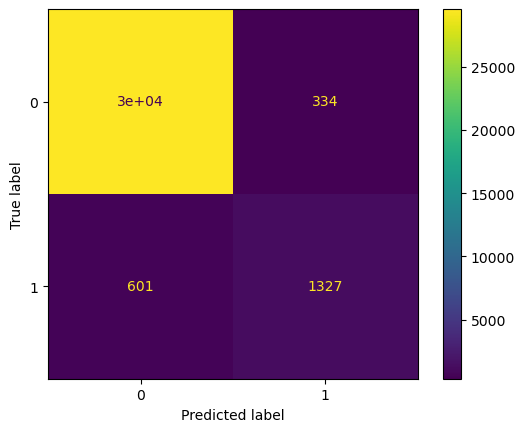

In [67]:
run_model(model, "pca85", param_grid=param_grid, n_iter=10)

Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'metric': 'minkowski', 'algorithm': 'brute'}
Time to train model: 1022.90 seconds
Balanced Accuracy (Train): 0.9861
Balanced Accuracy (Test): 0.8275
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     29890
           1       0.79      0.67      0.72      1928

    accuracy                           0.97     31818
   macro avg       0.88      0.83      0.85     31818
weighted avg       0.97      0.97      0.97     31818



<Figure size 600x400 with 0 Axes>

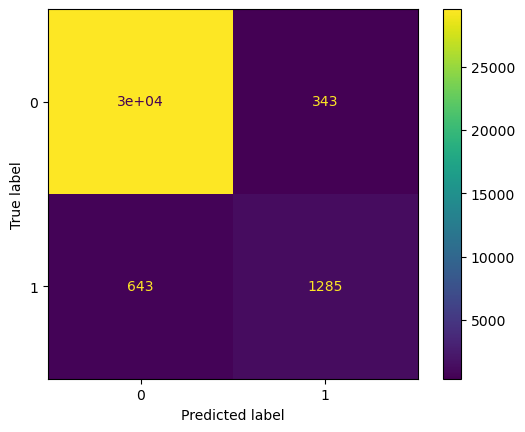

In [68]:
run_model(model, "pca60", param_grid=param_grid, n_iter=10)

## Decision Tree

Time to train model: 2.30 seconds
Balanced Accuracy (Train): 0.9974
Balanced Accuracy (Test): 0.8737
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     29890
           1       0.73      0.77      0.75      1928

    accuracy                           0.97     31818
   macro avg       0.86      0.87      0.87     31818
weighted avg       0.97      0.97      0.97     31818



<Figure size 600x400 with 0 Axes>

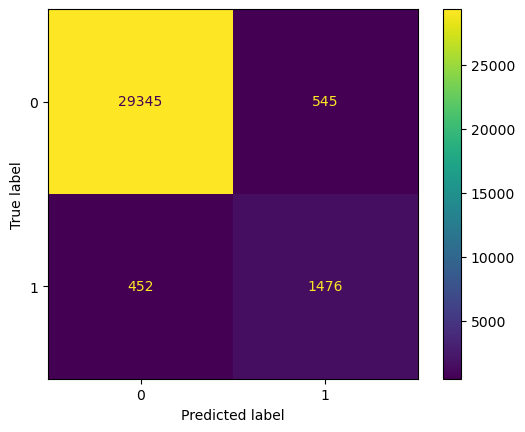

In [69]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight='balanced')
run_model(model, "raw")

In [70]:
param_grid =  {'max_depth': range(1, 51), 
               'ccp_alpha': [10**i for i in range(-7, 7)], 
               'min_samples_split': range(1, 101),
               'min_samples_leaf': range(1, 101),
               'criterion': ['gini', 'entropy', 'log_loss']
              }

Best Parameters: {'min_samples_split': 6, 'min_samples_leaf': 16, 'max_depth': 49, 'criterion': 'gini', 'ccp_alpha': 0.0001}
Time to train model: 19.31 seconds
Balanced Accuracy (Train): 0.9356
Balanced Accuracy (Test): 0.8985
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     29890
           1       0.36      0.90      0.51      1928

    accuracy                           0.90     31818
   macro avg       0.67      0.90      0.73     31818
weighted avg       0.95      0.90      0.92     31818



<Figure size 600x400 with 0 Axes>

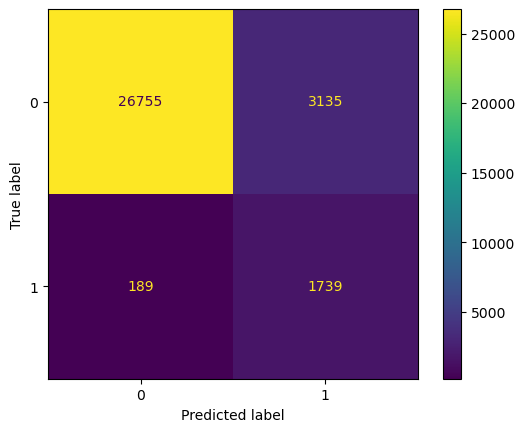

In [71]:
run_model(model, "raw", param_grid=param_grid, n_iter=100)

Optimal number of features: 9
Selected features: Index(['avg_task_size', 'lines_blank', 'lines_code', 'lines_comment',
       'num_conditions', 'num_keys', 'num_parameters', 'num_tokens',
       'text_entropy'],
      dtype='object')


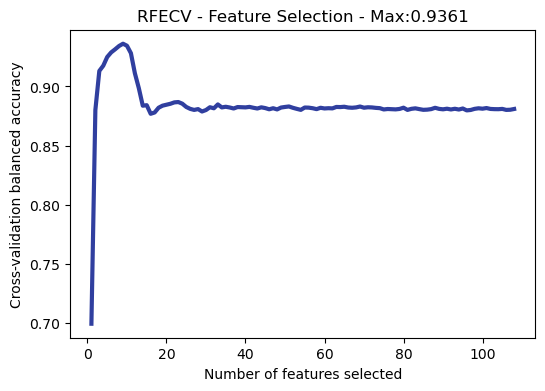

In [47]:
selected_features = feature_RFECV(model)

Best Parameters: {'min_samples_split': 6, 'min_samples_leaf': 16, 'max_depth': 49, 'criterion': 'gini', 'ccp_alpha': 0.0001}
Time to train model: 3.85 seconds
Balanced Accuracy (Train): 0.9365
Balanced Accuracy (Test): 0.9013
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     29890
           1       0.38      0.90      0.54      1928

    accuracy                           0.91     31818
   macro avg       0.69      0.90      0.74     31818
weighted avg       0.96      0.91      0.92     31818



<Figure size 600x400 with 0 Axes>

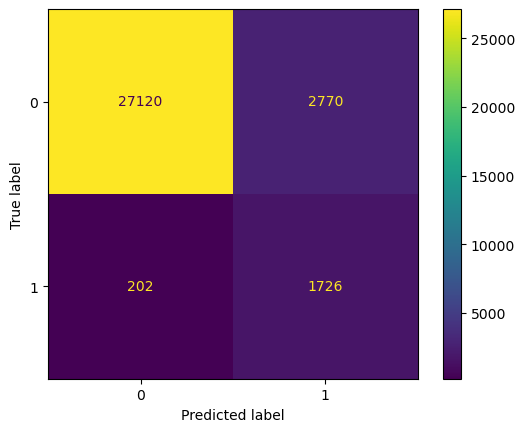

In [72]:
selected_features = ['avg_task_size', 'lines_blank', 'lines_code', 'lines_comment',
                     'num_conditions', 'num_keys', 'num_parameters', 'num_tokens',
                     'text_entropy']
run_model(model, "raw", selected_features, param_grid, n_iter=100)

## Random Forrest

Time to train model: 18.56 seconds
Balanced Accuracy (Train): 0.9972
Balanced Accuracy (Test): 0.8350
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     29890
           1       0.87      0.68      0.76      1928

    accuracy                           0.97     31818
   macro avg       0.93      0.84      0.87     31818
weighted avg       0.97      0.97      0.97     31818



<Figure size 600x400 with 0 Axes>

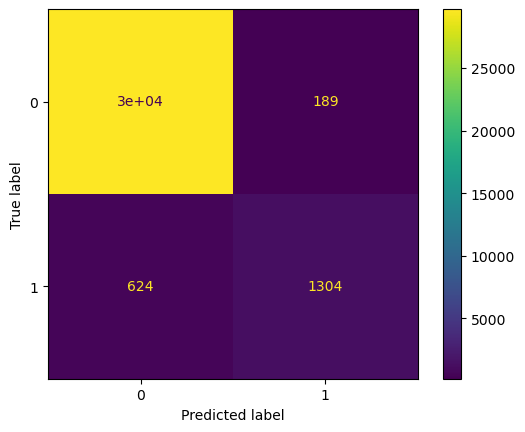

In [73]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced')
run_model(model, "raw")

In [75]:
param_grid = {"max_features" : range(1, 51),
              'max_depth': range(1, 51), 
              'min_samples_split': range(1, 101),
              'min_samples_leaf': range(1, 101),
              "bootstrap" : [True, False],
              "n_estimators" : range(10,310,10)}

Best Parameters: {'n_estimators': 100, 'min_samples_split': 48, 'min_samples_leaf': 48, 'max_features': 46, 'max_depth': 35, 'bootstrap': False}
Time to train model: 567.89 seconds
Balanced Accuracy (Train): 0.9537
Balanced Accuracy (Test): 0.9204
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     29890
           1       0.42      0.92      0.57      1928

    accuracy                           0.92     31818
   macro avg       0.70      0.92      0.76     31818
weighted avg       0.96      0.92      0.93     31818



<Figure size 600x400 with 0 Axes>

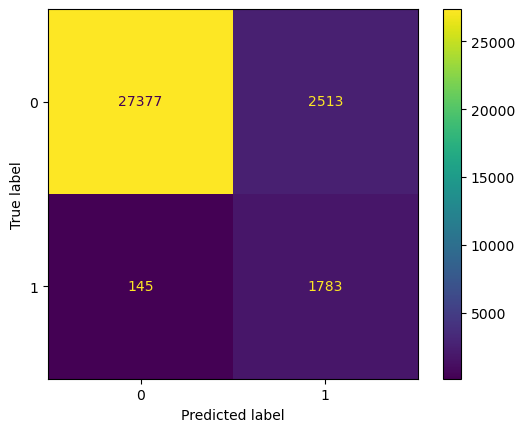

In [76]:
run_model(model, "raw", param_grid=param_grid, n_iter=100)

Optimal number of features: 10
Selected features: Index(['avg_task_size', 'lines_blank', 'lines_code', 'lines_comment',
       'num_conditions', 'num_keys', 'num_parameters', 'num_tokens',
       'num_unique_names', 'text_entropy'],
      dtype='object')


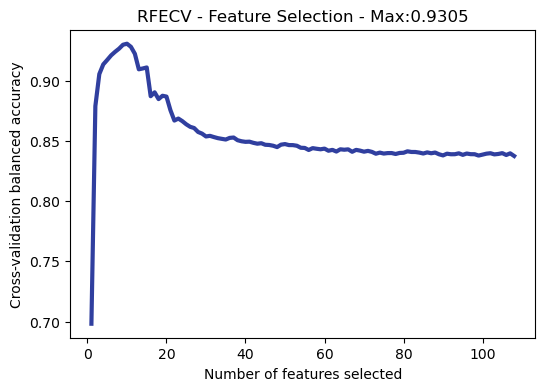

In [36]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced')
selected_features = feature_RFECV(model)

Best Parameters: {'n_estimators': 280, 'min_samples_split': 23, 'min_samples_leaf': 22, 'max_features': 5, 'max_depth': 31, 'bootstrap': False}
Time to train model: 432.36 seconds
Balanced Accuracy (Train): 0.9754
Balanced Accuracy (Test): 0.9413
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     29890
           1       0.57      0.93      0.71      1928

    accuracy                           0.95     31818
   macro avg       0.78      0.94      0.84     31818
weighted avg       0.97      0.95      0.96     31818



<Figure size 600x400 with 0 Axes>

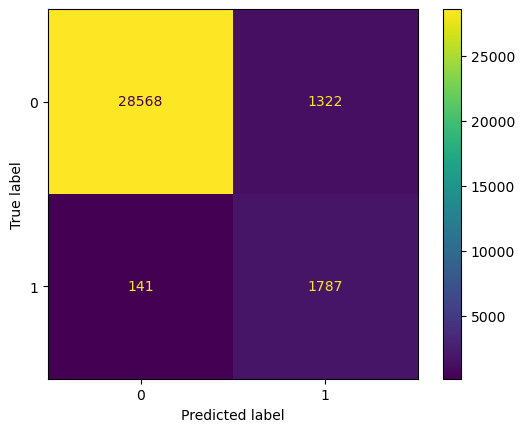

In [77]:
selected_features = ['avg_task_size', 'lines_blank', 'lines_code', 'lines_comment',
                     'num_conditions', 'num_keys', 'num_parameters', 'num_tokens',
                     'num_unique_names', 'text_entropy']
run_model(model, "raw", selected_features, param_grid, n_iter=100)

## Support Vector Classifier

Time to train model: 1338.49 seconds
Balanced Accuracy (Train): 0.8162
Balanced Accuracy (Test): 0.7680
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.86      0.91     29890
           1       0.23      0.68      0.35      1928

    accuracy                           0.85     31818
   macro avg       0.61      0.77      0.63     31818
weighted avg       0.93      0.85      0.88     31818



<Figure size 600x400 with 0 Axes>

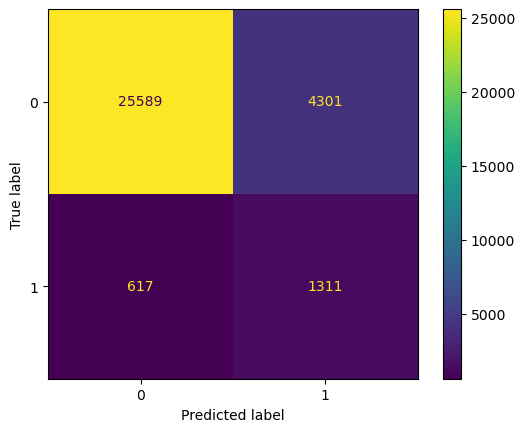

In [78]:
from sklearn.svm import SVC

model = SVC(class_weight='balanced', random_state=RANDOM_SEED)
run_model(model, "vif")    

Time to train model: 1537.28 seconds
Balanced Accuracy (Train): 0.8159
Balanced Accuracy (Test): 0.7675
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.86      0.91     29890
           1       0.23      0.68      0.35      1928

    accuracy                           0.84     31818
   macro avg       0.60      0.77      0.63     31818
weighted avg       0.93      0.84      0.88     31818



<Figure size 600x400 with 0 Axes>

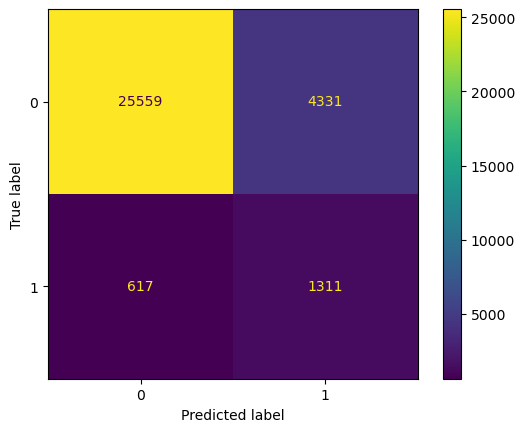

In [79]:
run_model(model, "pca85")   

Time to train model: 1359.77 seconds
Balanced Accuracy (Train): 0.7946
Balanced Accuracy (Test): 0.7511
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91     29890
           1       0.21      0.66      0.32      1928

    accuracy                           0.83     31818
   macro avg       0.59      0.75      0.61     31818
weighted avg       0.93      0.83      0.87     31818



<Figure size 600x400 with 0 Axes>

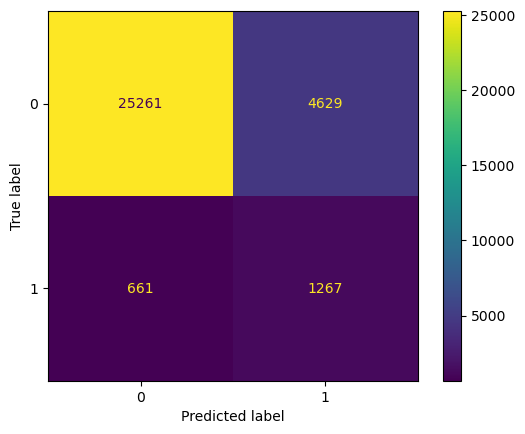

In [80]:
run_model(model, "pca60")   

## XGBoost Classifier

Time to train model: 1.25 seconds
Balanced Accuracy (Train): 0.9588
Balanced Accuracy (Test): 0.9176
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     29890
           1       0.46      0.90      0.61      1928

    accuracy                           0.93     31818
   macro avg       0.73      0.92      0.79     31818
weighted avg       0.96      0.93      0.94     31818



<Figure size 600x400 with 0 Axes>

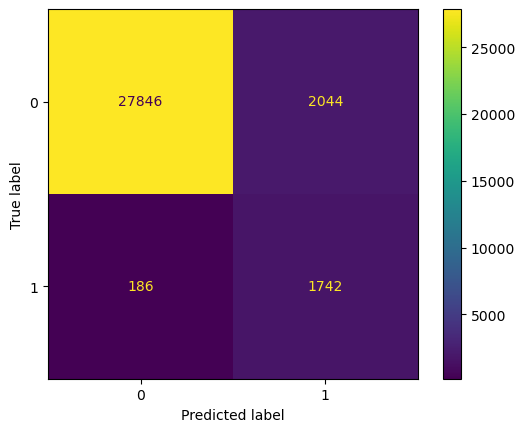

In [11]:
from xgboost import XGBClassifier
import xgboost as xgb

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
model = XGBClassifier(random_state=RANDOM_SEED, scale_pos_weight=class_weights[1] / class_weights[0])
run_model(model, "raw")

In [13]:
param_grid = {'learning_rate': np.arange(0, 0.51, 0.01), 
              "max_depth" : range(1, 50),
              "n_estimators" : range(10,310,10)}

Best Parameters: {'n_estimators': 260, 'max_depth': 13, 'learning_rate': 0.04}
Time to train model: 253.88 seconds
Balanced Accuracy (Train): 0.9921
Balanced Accuracy (Test): 0.9358
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     29890
           1       0.71      0.90      0.79      1928

    accuracy                           0.97     31818
   macro avg       0.85      0.94      0.89     31818
weighted avg       0.98      0.97      0.97     31818



<Figure size 600x400 with 0 Axes>

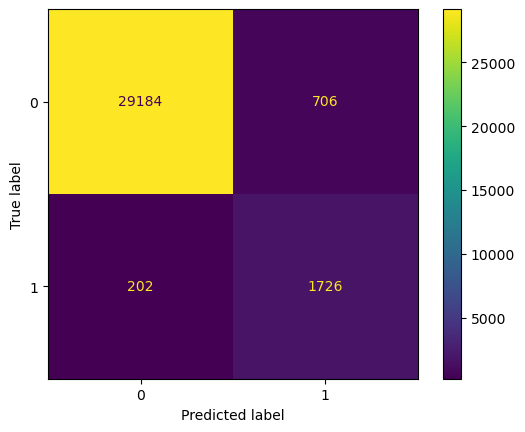

In [15]:
run_model(model, "raw", param_grid=param_grid, n_iter=15)

Optimal number of features: 34
Selected features: Index(['avg_play_size', 'avg_task_size', 'highest_contributor_experience',
       'lines_blank', 'lines_code', 'lines_comment', 'num_blocks',
       'num_commands', 'num_conditions', 'num_decisions',
       'num_deprecated_keywords', 'num_distinct_modules', 'num_file_mode',
       'num_file_modules', 'num_filters', 'num_ignore_errors',
       'num_import_tasks', 'num_include_role', 'num_include_tasks',
       'num_include_vars', 'num_keys', 'num_lookups', 'num_loops',
       'num_names_with_vars', 'num_parameters', 'num_paths', 'num_plays',
       'num_prompts', 'num_regex', 'num_tasks', 'num_tokens',
       'num_unique_names', 'num_vars', 'text_entropy'],
      dtype='object')


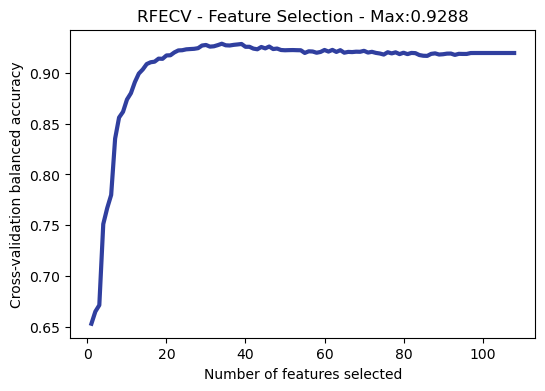

In [16]:
selected_features = feature_RFECV(model)

Best Parameters: {'n_estimators': 260, 'max_depth': 13, 'learning_rate': 0.04}
Time to train model: 117.15 seconds
Balanced Accuracy (Train): 0.9891
Balanced Accuracy (Test): 0.9503
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     29890
           1       0.73      0.92      0.82      1928

    accuracy                           0.98     31818
   macro avg       0.86      0.95      0.90     31818
weighted avg       0.98      0.98      0.98     31818



<Figure size 600x400 with 0 Axes>

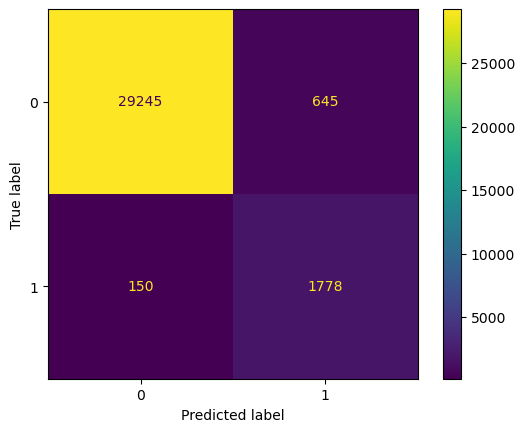

In [17]:
selected_features = ['avg_play_size', 'avg_task_size', 'highest_contributor_experience',
                     'lines_blank', 'lines_code', 'lines_comment', 'num_blocks',
                     'num_commands', 'num_conditions', 'num_decisions',
                     'num_deprecated_keywords', 'num_distinct_modules', 'num_file_mode',
                     'num_file_modules', 'num_filters', 'num_ignore_errors',
                     'num_import_tasks', 'num_include_role', 'num_include_tasks',
                     'num_include_vars', 'num_keys', 'num_lookups', 'num_loops',
                     'num_names_with_vars', 'num_parameters', 'num_paths', 'num_plays',
                     'num_prompts', 'num_regex', 'num_tasks', 'num_tokens',
                     'num_unique_names', 'num_vars', 'text_entropy']

run_model(model, "raw", selected_features, param_grid, n_iter=15)

In [157]:
def best_n_estimators(model, X_train):
    def balanced_accuracy(preds, dtrain):
        labels = dtrain.get_label()
        preds = np.round(preds)
        score = balanced_accuracy_score(labels, preds)
        return 'balanced_accuracy', score
    
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
    )
    xgb_param = model.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train_split, label=y_train_split)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5,
                      feval=balanced_accuracy, early_stopping_rounds=50)
    
    print("Best n_estimators:", cvresult.shape[0])
    model.set_params(n_estimators=cvresult.shape[0])
    
    model.fit(X_train_split, y_train_split)
            
    y_pred_split = model.predict(X_train_split)
    train_bal_acc = balanced_accuracy_score(y_train_split, y_pred_split)
    print(f"Balanced Accuracy (Train): {train_bal_acc:.4f}")
    
    y_pred_split = model.predict(X_test_split)
    test_bal_acc = balanced_accuracy_score(y_test_split, y_pred_split)
    print(f"Balanced Accuracy (Test): {test_bal_acc:.4f}")

In [162]:
model = XGBClassifier(random_state=RANDOM_SEED, learning_rate =0.3, n_estimators=5000,scale_pos_weight=class_weights[1] / class_weights[0])
best_n_estimators(model, X_train_versions["raw"][selected_features])

Best n_estimators: 588
Balanced Accuracy (Train): 0.9911
Balanced Accuracy (Test): 0.9463


Best Parameters: {'subsample': 0.7500000000000002, 'reg_alpha': 1e-06, 'min_child_weight': 7, 'max_depth': 6, 'gamma': 0.4, 'colsample_bytree': 0.7000000000000002}
Time to train model: 66.65 seconds
Balanced Accuracy (Train): 0.9883
Balanced Accuracy (Test): 0.9515
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     29890
           1       0.71      0.93      0.80      1928

    accuracy                           0.97     31818
   macro avg       0.85      0.95      0.89     31818
weighted avg       0.98      0.97      0.97     31818



<Figure size 600x400 with 0 Axes>

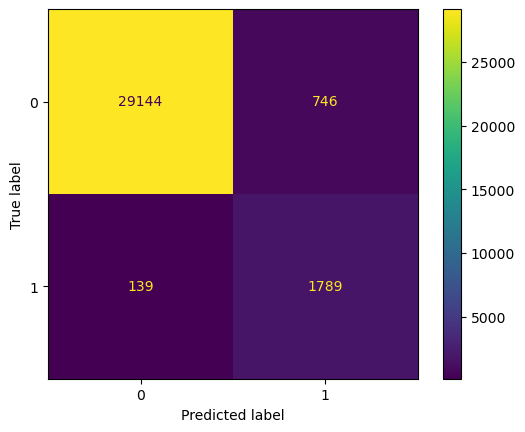

In [178]:
param_grid = {'max_depth':range(3,20),
              'min_child_weight':range(1,10),
              'gamma': np.arange(0, 0.5, 0.05),
              'subsample':np.arange(0.5, 1.05, 0.05),
              'colsample_bytree':np.arange(0.5, 1.05, 0.05),
              'reg_alpha':[10**i for i in range(-7, 7)]
             }
model = XGBClassifier(random_state=RANDOM_SEED, learning_rate=0.3, n_estimators=588,scale_pos_weight=class_weights[1] / class_weights[0])
run_model(model, "raw", selected_features, param_grid=param_grid, n_iter=500)

In [182]:
model = XGBClassifier(random_state=RANDOM_SEED, 
                      learning_rate =0.05, 
                      n_estimators=5000,
                      scale_pos_weight=class_weights[1] / class_weights[0],
                      subsample = 0.75, 
                      reg_alpha = 1e-06, 
                      min_child_weight = 7,
                      max_depth = 6, 
                      gamma = 0.4, 
                      colsample_bytree = 0.7)
best_n_estimators(model, X_train_versions["raw"][selected_features])

Best n_estimators: 1796
Balanced Accuracy (Train): 0.9830
Balanced Accuracy (Test): 0.9492


Best Parameters: {'n_estimators': 588, 'learning_rate': 0.2}
Time to train model: 112.38 seconds
Balanced Accuracy (Train): 0.9857
Balanced Accuracy (Test): 0.9516
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     29890
           1       0.68      0.93      0.78      1928

    accuracy                           0.97     31818
   macro avg       0.84      0.95      0.88     31818
weighted avg       0.98      0.97      0.97     31818



<Figure size 600x400 with 0 Axes>

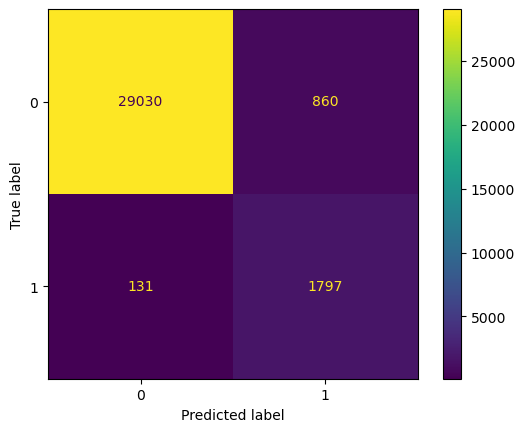

In [206]:
param_grid = {'learning_rate': np.arange(0, 0.51, 0.01),
              'n_estimators' : [588, 1796]
             }

model = XGBClassifier(random_state=RANDOM_SEED, 
                      scale_pos_weight=class_weights[1] / class_weights[0],
                      subsample = 0.75, 
                      reg_alpha = 1e-06, 
                      min_child_weight = 7,
                      max_depth = 6, 
                      gamma = 0.4, 
                      colsample_bytree = 0.7
                     )
run_model(model, "raw", selected_features, param_grid=param_grid, n_iter=150)